In [1]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
import re
import numpy as np

file_path = "/home/jlascar/Documents/Chess/experiments/Expe3/lichess-2025-07_SF.jsonl"

## Proportion de coup légaux

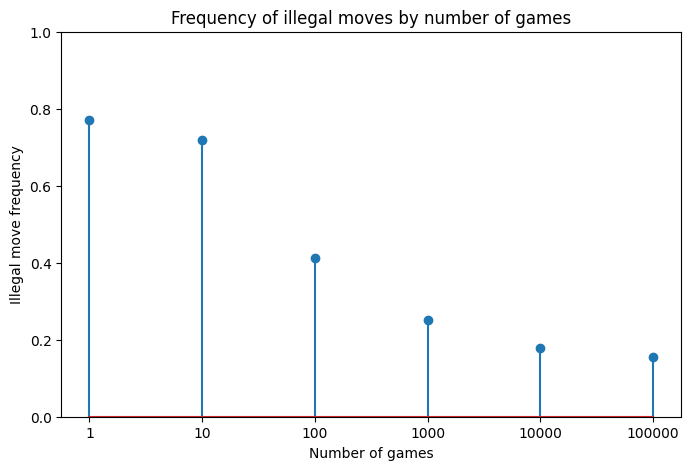

In [2]:
illegal_counts = defaultdict(int)  # compteur des coups illégaux / totaux
total_counts = defaultdict(int)

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        olp = data.get("OLP", {})

        for model, value in olp.items():
            if model.endswith("_norules"):
                nb_games = model.split("_")[0]
                total_counts[nb_games] += 1
                pred = value.get("SF_score", "")
                if pred == "illegal":
                    illegal_counts[nb_games] += 1

frequencies = {k: illegal_counts[k] / total_counts[k] for k in total_counts}

sorted_keys = sorted(frequencies.keys(), key=lambda x: int(x))
x = sorted_keys
y = [frequencies[k] for k in sorted_keys]

plt.figure(figsize=(8, 5))
plt.stem(x, y)
plt.xlabel("Number of games")
plt.ylabel("Illegal move frequency")
plt.title("Frequency of illegal moves by number of games")
plt.ylim(0, 1)
plt.show()

## Comparaison avec le meilleur coup de Stockfish

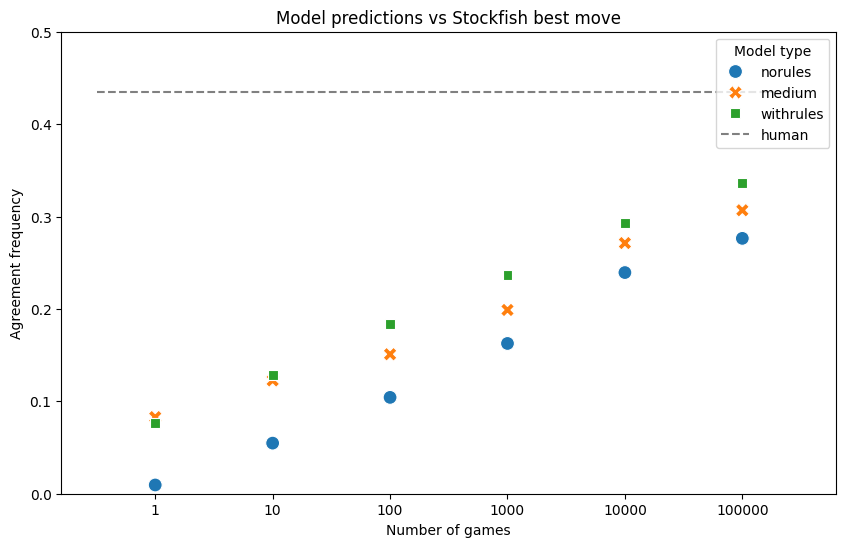

In [4]:
# dictionnaire pour compter les accords avec Stockfish
counts = defaultdict(lambda: defaultdict(int))
totals = defaultdict(lambda: defaultdict(int))

model_types = ["norules", "medium", "withrules"]

human_counts =  []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        stockfish_move = data.get("stockfish", {}).get("best_move")
        olp = data.get("OLP", {})
        human_move = data.get("human", {}).get("next_move")

        for model, value in olp.items():
            for model_type in model_types:
                if model.endswith(model_type):
                    nb_games = model.split("_")[0]
                    totals[nb_games][model_type] += 1
                    pred = value.get("prediction", "")
                    if pred == stockfish_move:
                        counts[nb_games][model_type] += 1
        # humain
        nb_games_keys = set(k.split("_")[0] for k in olp.keys() if any(m in k for m in model_types))
        human_counts.append(int(human_move == stockfish_move))

records = []
for nb_games in sorted(totals.keys(), key=lambda x: int(x)):
    for model in model_types:
        frequency = counts[nb_games][model] / totals[nb_games][model]  # fréquence
        records.append({"Number of games": nb_games, "Model type": model, "Agreement frequency": frequency})

# ajout humain
human_frequency = sum(human_counts) / len(human_counts)

df = pd.DataFrame(records)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Number of games", y="Agreement frequency", hue="Model type", style="Model type", s=100)

# ligne horizontale pour humain
plt.hlines(
    human_frequency,
    xmin=-0.5,
    xmax=len(df["Number of games"].unique()) - 0.5,
    colors="gray",
    linestyles="dashed",
    label="human",
)

plt.xlabel("Number of games")
plt.ylabel("Agreement frequency")
plt.title("Model predictions vs Stockfish best move")
plt.ylim(0, 0.5)
plt.legend(title="Model type")
plt.show()

## Nombre de mats positifs forcés

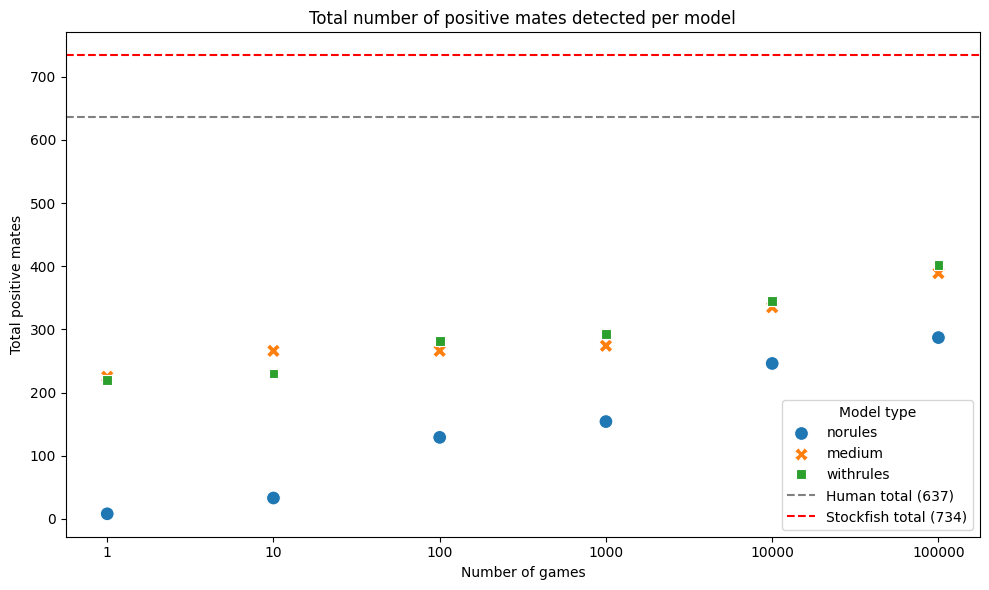

In [ ]:
def is_positive_mate(score):
    """Retourne True si le score SF indique un mat positif."""
    if isinstance(score, str) and re.match(r"mat\+\d+", score):
        return True
    return False

# --- Structures de comptage ---
counts_mate = defaultdict(lambda: defaultdict(int))   # nb total de mats+ détectés par modèle
totals = defaultdict(lambda: defaultdict(int))        # nb total de positions
human_mates = []
stockfish_mates = []

model_types = ["norules", "medium", "withrules"]

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        sf_score = data.get("stockfish", {}).get("SF_score")
        human_score = data.get("human", {}).get("SF_score")
        olp = data.get("OLP", {})

        # Vérifie si SF ou humain ont un mat+
        stockfish_has_mate = is_positive_mate(sf_score)
        human_has_mate = is_positive_mate(human_score)

        human_mates.append(int(human_has_mate))
        stockfish_mates.append(int(stockfish_has_mate))

        # nb_games présents pour cette ligne
        nb_games_keys = set(k.split("_")[0] for k in olp.keys() if any(m in k for m in model_types))
        
        # --- Comptage OLP ---
        for model, values in olp.items():
            for model_type in model_types:
                if model.endswith(model_type):
                    nb_games = model.split("_")[0]
                    totals[nb_games][model_type] += 1
                    score_pred = values.get("SF_score")
                    if is_positive_mate(score_pred):
                        counts_mate[nb_games][model_type] += 1

records = []

sorted_keys = sorted(totals.keys(), key=lambda x: int(x))

for nb_games in sorted_keys:
    for model_type in model_types:
        if totals[nb_games][model_type] > 0:
            total_mates = counts_mate[nb_games][model_type]
            records.append({
                "Number of games": str(nb_games),  
                "Model type": model_type,
                "Total positive mates": total_mates
            })

# Comptage total pour human et stockfish 
human_total = sum(human_mates)
stockfish_total = sum(stockfish_mates)


# --- Visualisation ---
df = pd.DataFrame(records)
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="Number of games",
    y="Total positive mates",
    hue="Model type",
    style="Model type",
    s=100
)

# Lignes horizontales : total de mats pour human et stockfish
if human_total:
    plt.axhline(y=human_total, color="gray", linestyle="--", label=f"Human total ({human_total})")

if stockfish_total:
    plt.axhline(y=stockfish_total, color="red", linestyle="--", label=f"Stockfish total ({stockfish_total})")

plt.xlabel("Number of games")
plt.ylabel("Total positive mates")
plt.title("Total number of positive mates detected per model")
plt.legend(title="Model type")
plt.tight_layout()
plt.show()


## Nombre de mats négatifs forcés

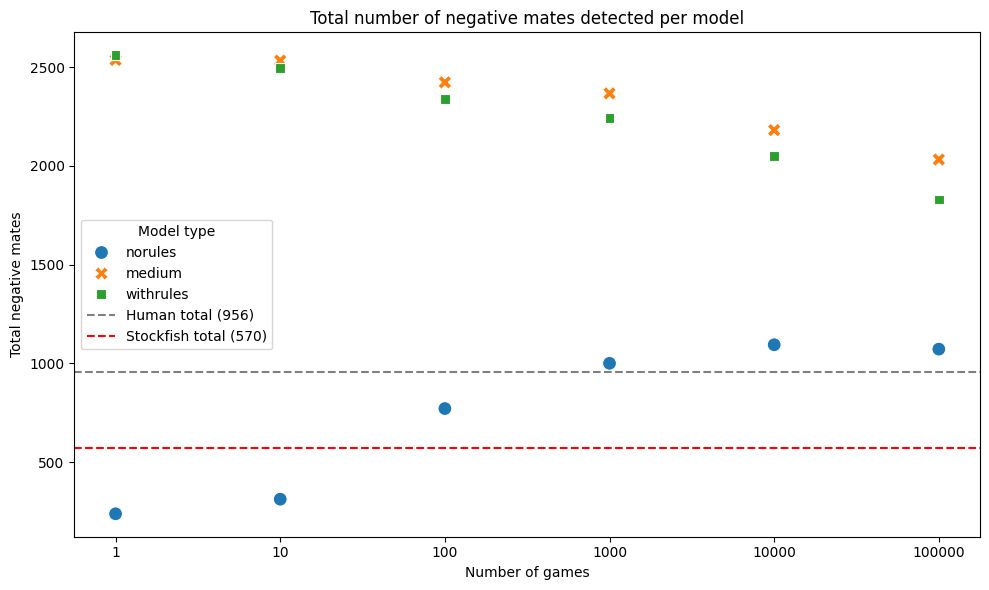

In [6]:
def is_negative_mate(score):
    """Retourne True si le score SF indique un mat négatif."""
    if isinstance(score, str) and re.match(r"mat-\d+", score) :
        return True
    return False


# --- Structures de comptage ---
counts_mate = defaultdict(lambda: defaultdict(int))   # nb total de mats- détectés par modèle
totals = defaultdict(lambda: defaultdict(int))        # nb total de positions
human_neg_mates = []
stockfish_neg_mates = []

model_types = ["norules", "medium", "withrules"]

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        sf_score = data.get("stockfish", {}).get("SF_score") 
        human_score = data.get("human", {}).get("SF_score")
        olp = data.get("OLP", {})

        # Vérifie si SF ou humain ont un mat négatif
        stockfish_has_neg_mate = is_negative_mate(sf_score) # Boolean indiquant si SF a mat-
        human_has_neg_mate = is_negative_mate(human_score) # Boolean indiquant si humain a mat-

        human_neg_mates.append(int(human_has_neg_mate))
        stockfish_neg_mates.append(int(stockfish_has_neg_mate))

        # nb_games présents pour cette ligne
        nb_games_keys = set(k.split("_")[0] for k in olp.keys() if any(m in k for m in model_types))

        # --- Comptage OLP ---
        for model, values in olp.items():
            for model_type in model_types:
                if model.endswith(model_type):
                    nb_games = model.split("_")[0]
                    totals[nb_games][model_type] += 1
                    score_pred = values.get("SF_score")
                    if is_negative_mate(score_pred):
                        counts_mate[nb_games][model_type] += 1

records = []

sorted_keys = sorted(totals.keys(), key=lambda x: int(x))

for nb_games in sorted_keys:
    for model in model_types:
        if totals[nb_games][model] > 0:
            total_mates = counts_mate[nb_games][model]
            records.append({
                "Number of games": str(nb_games),  
                "Model type": model,
                "Total positive mates": total_mates
            })

# Comptage total pour human et stockfish 
human_total = sum(human_neg_mates)
stockfish_total = sum(stockfish_neg_mates)


# --- Visualisation ---
df = pd.DataFrame(records)
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="Number of games",
    y="Total positive mates",
    hue="Model type",
    style="Model type",
    s=100
)

# Lignes horizontales : total de mats pour human et stockfish
if human_total:
    plt.axhline(y=human_total, color="gray", linestyle="--", label=f"Human total ({human_total})")
if stockfish_total:
    plt.axhline(y=stockfish_total, color="red", linestyle="--", label=f"Stockfish total ({stockfish_total})")

plt.xlabel("Number of games")
plt.ylabel("Total negative mates")
plt.title("Total number of negative mates detected per model")
plt.legend(title="Model type")
plt.tight_layout()
plt.show()


## Json à Dataframe pour mettre les scores SF pour tous les modèles

In [2]:
rows = []

def convert_score(value):
    """Convertit les SF_scores :
    - float si possible
    - garde la chaîne sinon
    """
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        try:
            return float(value)
        except ValueError:
            return value  
    return value

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        row = {"id": entry["id"]}

        # Stockfish & Human
        row["stockfish"] = convert_score(entry.get("stockfish", {}).get("SF_score"))
        row["human"] = convert_score(entry.get("human", {}).get("SF_score"))

        # Tous les modèles OLP
        for model_name, model_data in entry.get("OLP", {}).items():
            key = model_name
            row[key] = convert_score(model_data.get("SF_score"))

        rows.append(row)

# Créer le DataFrame
df = pd.DataFrame(rows)

# --- Ajouter la colonne all_numeric ---
sf_cols = [c for c in df.columns if not c.startswith("id")]
df["all_numeric"] = df[sf_cols].apply(
    lambda row: all(isinstance(x, (int, float)) for x in row),
    axis=1
)


print(df.head())


    id stockfish human 1_norules 1_medium 1_withrules 10_norules 10_medium  \
0  0_0      33.0  33.0       4.0      4.0         4.0       33.0      33.0   
1  0_1     -33.0 -33.0   illegal    -66.0       -68.0      -30.0     -30.0   
2  0_2      41.0  41.0       7.0      7.0         7.0    illegal      41.0   
3  0_3     -35.0 -57.0   illegal    -91.0      -114.0      -35.0     -35.0   
4  0_4      40.0  40.0       9.0      9.0         9.0    illegal      40.0   

  10_withrules 100_norules  ... 1000_norules 1000_medium 1000_withrules  \
0         33.0        33.0  ...         33.0        33.0           33.0   
1        -30.0       -30.0  ...        -33.0       -33.0          -33.0   
2         41.0        14.0  ...         41.0        41.0           41.0   
3        -35.0       -35.0  ...        -35.0       -35.0          -35.0   
4        -28.0        40.0  ...         40.0        40.0           40.0   

  10000_norules 10000_medium 10000_withrules 100000_norules 100000_medium  \
0  

## Scores SF en ne prenant que les lignes sans scores de type 'litteral' (coups illégaux, mats)

In [19]:
df_clean = df[df["all_numeric"]].copy()
sf_cols = [c for c in df_clean.columns if c not in ("id", "all_numeric")]
print(len(df_clean), "rows with all numeric scores.")
# Convertir en numérique
df_clean[sf_cols] = df_clean[sf_cols].apply(pd.to_numeric, errors="coerce")

# Résumé numérique complet
desc = df_clean[sf_cols].describe().T

# Supprimer la colonne 'count'
desc = desc.drop(columns=["count"])

print(desc)


5858 rows with all numeric scores.
                       mean         std     min     25%   50%    75%     max
stockfish         34.456470  104.039316  -655.0    8.00  33.0  52.00  1197.0
human             16.139638  110.899401 -1010.0  -14.00  28.0  39.00  1197.0
1_norules        -80.996244  187.965226 -1098.0  -94.75 -11.0   4.00   779.0
1_medium         -80.996244  187.965226 -1098.0  -94.75 -11.0   4.00   779.0
1_withrules      -93.812052  200.210548 -1198.0 -108.00 -19.0   4.00   710.0
10_norules       -51.507853  188.860481 -1185.0  -65.00  18.0  33.00  1197.0
10_medium        -51.507853  188.860481 -1185.0  -65.00  18.0  33.00  1197.0
10_withrules     -56.841755  191.948354 -1095.0  -67.00  16.0  33.00   765.0
100_norules      -44.569819  183.861962 -1175.0  -53.00  22.0  33.00   929.0
100_medium       -44.569819  183.861962 -1175.0  -53.00  22.0  33.00   929.0
100_withrules    -40.649198  185.426923  -998.0  -42.00  24.0  33.00   742.0
1000_norules     -28.756060  169.549284 -

In [3]:
for nbgames in [1, 10, 100, 1000, 10000, 100000]:
    # Sélection des colonnes : celles du modèle + human/stockfish
    cols = [c for c in df.columns if (c.startswith(f"{nbgames}_") or c in ("human", "stockfish"))]
    
    # Convertir les valeurs en numérique (les strings deviennent NaN)
    df_subset = df[cols].apply(pd.to_numeric, errors="coerce")
    
    # Supprimer les lignes contenant des NaN (donc non numériques)
    df_subset_clean = df_subset.dropna()
    
    # Calcul des stats sans la colonne count
    desc = df_subset_clean.describe().T.drop(columns=["count"])
    
    print(f"=== Modèles qui commencent par '{nbgames}_' ===")
    print("Nombre de lignes entièrement numériques :", len(df_subset_clean))
    print(desc)
    print()


=== Modèles qui commencent par '1_' ===
Nombre de lignes entièrement numériques : 16259
                   mean         std     min    25%   50%   75%     max
stockfish     36.196691  189.440042 -1121.0  -19.0  33.0  75.0  3487.0
human          6.880251  195.706263 -1445.0  -46.0  19.0  57.0  3414.0
1_norules   -146.933575  275.718758 -4442.0 -285.5 -52.0   4.0  3508.0
1_medium    -146.933575  275.718758 -4442.0 -285.5 -52.0   4.0  3508.0
1_withrules -173.162372  285.580425 -3970.0 -365.0 -67.0   4.0  3508.0

=== Modèles qui commencent par '10_' ===
Nombre de lignes entièrement numériques : 19722
                    mean         std     min    25%   50%   75%     max
stockfish      31.944833  264.872928 -4042.0  -36.0  17.0  63.0  4446.0
human           3.930534  277.160882 -4042.0  -59.0   0.0  43.0  9605.0
10_norules   -131.031792  335.015382 -4796.0 -249.0 -40.0  27.0  4446.0
10_medium    -131.031792  335.015382 -4796.0 -249.0 -40.0  27.0  4446.0
10_withrules -146.854629  337.563090

## Transformer scores de type littéral en nombre (+/- 10000)

In [20]:
def convert_special_score(x):
    if isinstance(x, (int, float)):
        return x
    if isinstance(x, str):
        x_lower = x.lower()
        if x_lower.startswith("mat") or x_lower == "illegal":
            if "+" in x_lower or x_lower == "mat0":
                return 10000
            else:  # mat-,  illegal
                return -10000
    return np.nan  

score_cols = [c for c in df.columns if c not in ("id", "all_numeric")]

df[score_cols] = df[score_cols].applymap(convert_special_score)

print(df.head())


/tmp/ipykernel_5767/1540889458.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[score_cols] = df[score_cols].applymap(convert_special_score)


    id  stockfish  human  1_norules  1_medium  1_withrules  10_norules  \
0  0_0       33.0   33.0        4.0       4.0          4.0        33.0   
1  0_1      -33.0  -33.0   -10000.0     -66.0        -68.0       -30.0   
2  0_2       41.0   41.0        7.0       7.0          7.0    -10000.0   
3  0_3      -35.0  -57.0   -10000.0     -91.0       -114.0       -35.0   
4  0_4       40.0   40.0        9.0       9.0          9.0    -10000.0   

   10_medium  10_withrules  100_norules  ...  1000_norules  1000_medium  \
0       33.0          33.0         33.0  ...          33.0         33.0   
1      -30.0         -30.0        -30.0  ...         -33.0        -33.0   
2       41.0          41.0         14.0  ...          41.0         41.0   
3      -35.0         -35.0        -35.0  ...         -35.0        -35.0   
4       40.0         -28.0         40.0  ...          40.0         40.0   

   1000_withrules  10000_norules  10000_medium  10000_withrules  \
0            33.0           33.0     

In [7]:
sf_cols = [c for c in df.columns if c not in ("id", "all_numeric")]
print(len(df), "rows with all numeric scores.")

# Convertir en numérique
df[sf_cols] = df[sf_cols].apply(pd.to_numeric, errors="coerce")

# Résumé numérique complet
desc = df[sf_cols].describe().T

# Supprimer la colonne 'count'
desc = desc.drop(columns=["count", "min","max"])
cols_sorted = desc["mean"].sort_values(ascending=False).index.tolist()
desc_sorted = desc.loc[cols_sorted]
print(desc_sorted)



72169 rows with all numeric scores.
                         mean          std      25%      50%      75%
stockfish           72.885131  1519.692763    -72.0      6.0    112.0
human              -33.723247  1626.817507   -116.0     -5.0     76.0
100000_withrules  -286.886627  1820.124731   -295.0    -32.0     40.0
100000_medium     -324.059666  1880.666646   -309.0    -33.0     37.0
10000_withrules   -353.048470  1867.996220   -369.0    -39.0     33.0
10000_medium      -377.322368  1899.280432   -370.0    -42.0     33.0
1000_withrules    -422.725492  1904.723631   -442.0    -60.0     27.0
1000_medium       -444.404024  1931.497761   -435.0    -64.0     25.0
100_withrules     -470.378376  1927.653178   -496.0    -89.0     15.0
100_medium        -470.677147  1944.164274   -461.0    -83.0     15.0
10_medium         -505.436891  1976.781985   -487.0   -107.0      6.0
1_medium          -520.925411  1962.374515   -495.0   -119.0      0.0
10_withrules      -529.592692  1951.723212   -527.0   

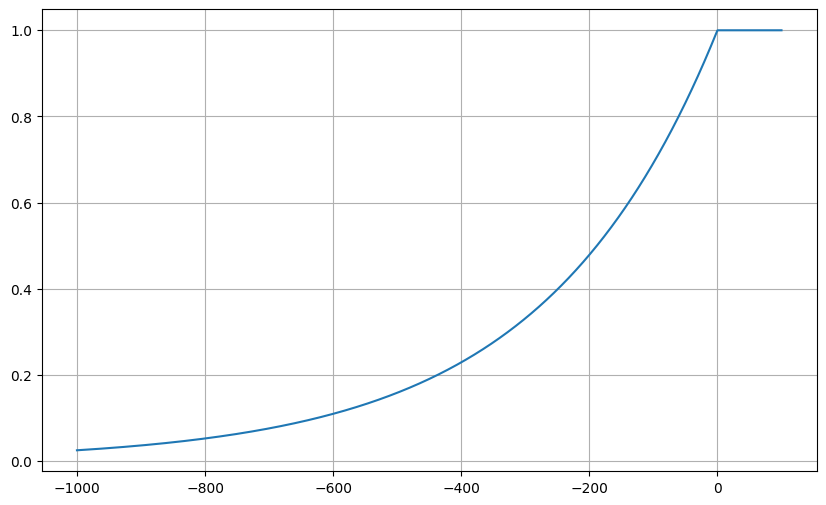

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

k = 0.00368208
def f_score(delta):
    if delta is None :
        return 0
    elif delta > 0:
        return 1
    else:
        return math.exp(k * delta)

# créer un vecteur de delta
deltas = np.linspace(-1000, 100, 2000)
f_values = [f_score(d) for d in deltas]

# tracer
plt.figure(figsize=(10, 6))
plt.plot(deltas, f_values)
plt.grid(True)
plt.show()


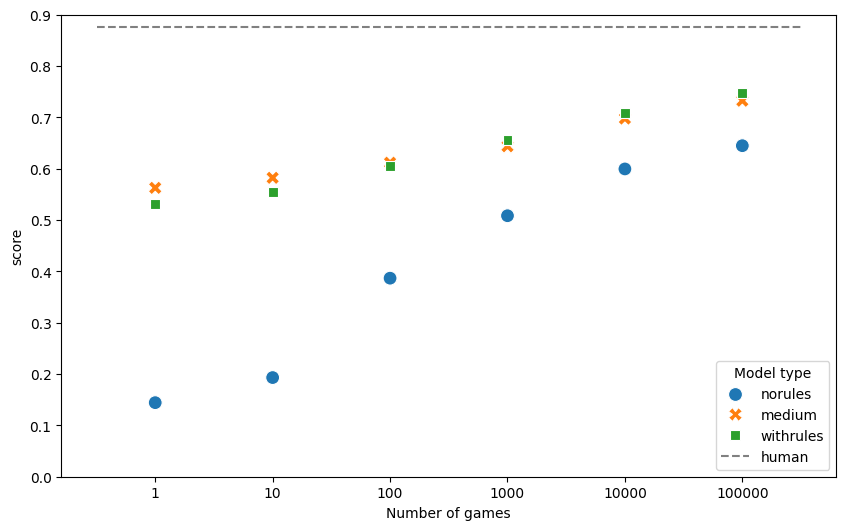

In [ ]:
values = defaultdict(lambda: defaultdict(list))
model_types = ["norules", "medium", "withrules"]
human_list = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        olp = data.get("OLP", {})

        # modèles
        for key, pred_info in olp.items():
            for model in model_types:
                if key.endswith(f"_{model}"):
                    delta = pred_info.get("delta")
                    nb_games = key.split("_")[0]
                    values[nb_games][model].append(f_score(delta))

         # Humain
        delta_h = data["human"].get("delta")
        human_list.append(f_score(delta_h))

records = []
for nb_games in sorted(values.keys(), key=lambda x: int(x)):
    for model in model_types:
        score_list = values[nb_games].get(model, [])
        if score_list:
            mean_score = sum(score_list) / len(score_list)
            records.append({
                "Number of games": nb_games,
                "Model type": model,
                "Mean score": mean_score
            })
# moyenne humain
human_mean = sum(human_list) / len(human_list)

df = pd.DataFrame(records)

# graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Number of games", y="Mean score",
                hue="Model type", style="Model type", s=100)

# ligne horizontale en pointillé pour humain
plt.hlines(y=human_mean,
            xmin=-0.5,
            xmax=len(df["Number of games"].unique()) - 0.5,
            colors="gray",
            linestyles="dashed",
            label="human" )

plt.xlabel("Number of games")
plt.ylabel("score")
plt.ylim(0, 0.9)
plt.legend(title="Model type", loc="lower right")
plt.show()
